In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFTdev, ADSTFT, ADSTFTfix, ADSTFTenergy, fastDSTFT

device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
#device = torch.device("mps")
print(device, torch.__version__)
torch.manual_seed(1802)

cpu 2.6.0


In [2]:
mat = loadmat("../data/fan_flutter.mat")["x"]
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

101
tensor(0.00366103951819241047, grad_fn=<AbsBackward0>)
tensor(0.00366104044951498508, grad_fn=<AbsBackward0>)
Elapsed time: 2.7650 seconds
Elapsed time: 0.8440 seconds
tensor(0.00366103951819241047, grad_fn=<AbsBackward0>)
tensor(0.00366103951819241047, grad_fn=<AbsBackward0>)
0.0
0.0
0.0


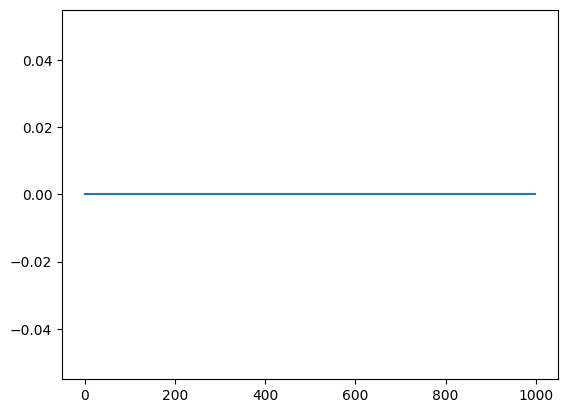

'\ndiff = specfix - spec\nprint(diff.shape)\nprint("specfix", specfix.shape)\nprint("spec", spec.shape)\nprint(diff[0, 500, 0])\nprint("diff", diff.max(), diff.min(), diff.mean())\ndiff_f = diff.squeeze(0).mean(dim=1).detach().numpy()\nplt.plot(diff_f[-10:])\nplt.show()\nadstft.plot(diff, x, bar=True, wins=False, weights=False)\n\nbackdiff = specbackfix - specback\nprint("diff", backdiff.max(), backdiff.min(), backdiff.mean())\nbackdiff_f = backdiff.squeeze(0).mean(dim=1).detach().numpy()\nplt.plot(backdiff_f[-10:])\nplt.show()\nadstft.plot(backdiff, x, bar=True, wins=False, weights=False)\n'

In [6]:
#dstftdev = DSTFTdev(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
#               ).to(device)
#tic()
#specdev, *_ = dstftdev(x)
#toc()
adstftfix = ADSTFTfix(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)
tic()
specfix, *_ = adstftfix(x)
coefffix = adstftfix.kasper
tapfix = adstftfix.tapered_x[0, 0, 500, :]
#entropy_loss(specfix).backward()
#temp = adstftfix.win_length.grad
#print("temp", temp.shape)
#print("specfix", specfix.shape)
#adstftfix.plot(temp[None, :, :], x, bar=True, wins=False, weights=False)
#specbackfix = adstftfix.win_length.grad[:501, :]
toc()
adstft = ADSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)
tic()
spec, *_ = adstft(x)
coeff = adstft.kasper
tap = adstft.tapered_x[0, 0, 500, :]
#entropy_loss(spec).backward()
#specback = adstft.win_length.grad
toc()

torch.set_printoptions(precision=20)
print((coeff*tap).sum(dim=-1).abs())
print((coefffix*tapfix).sum(dim=-1).abs())
torch.set_printoptions(precision=4)

import numpy as np
diff = [np.abs(k.detach().numpy()-kf.detach().numpy()) for (k, kf) in zip(coeff, coefffix)]
print(np.min(diff))
print(np.max(diff))
print(np.mean(diff))
plt.plot(diff)
plt.show()

"""
diff = specfix - spec
print(diff.shape)
print("specfix", specfix.shape)
print("spec", spec.shape)
print(diff[0, 500, 0])
print("diff", diff.max(), diff.min(), diff.mean())
diff_f = diff.squeeze(0).mean(dim=1).detach().numpy()
plt.plot(diff_f[-10:])
plt.show()
adstft.plot(diff, x, bar=True, wins=False, weights=False)

backdiff = specbackfix - specback
print("diff", backdiff.max(), backdiff.min(), backdiff.mean())
backdiff_f = backdiff.squeeze(0).mean(dim=1).detach().numpy()
plt.plot(backdiff_f[-10:])
plt.show()
adstft.plot(backdiff, x, bar=True, wins=False, weights=False)
"""

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/projekt-fmsn35/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


average time per iteration: 5.8516 seconds
174


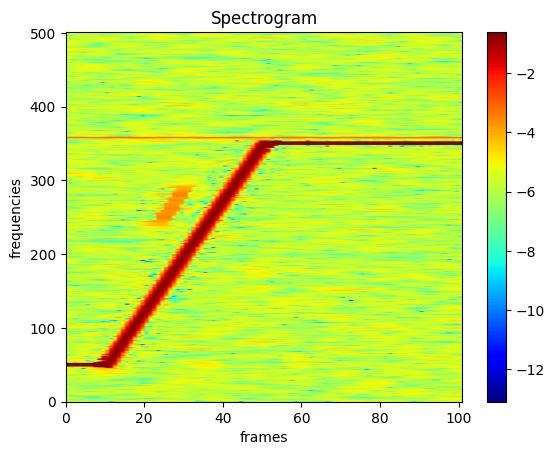

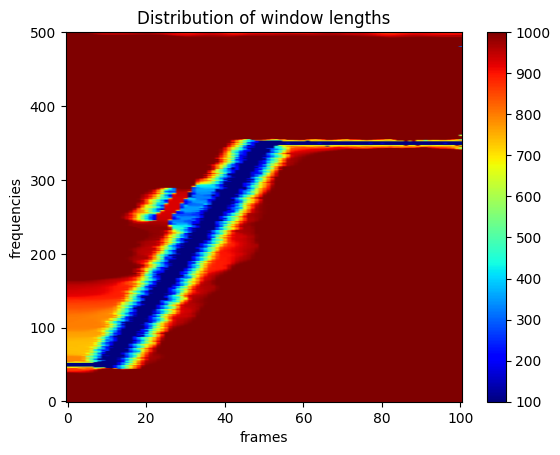

In [104]:
dstft = DSTFTdev(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

times = []
for epoch in range(1_000):
    tic()
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    times.append(toc(print_elapsed=False))
avgtime = sum(times) / len(times)
print(f"average time per iteration: {avgtime:.4f} seconds") 

print(epoch)
dstft.print(spec, x, bar=True, wins=False)

savedwindows = dstft.win_length.detach()

In [3]:
dstft = ADSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)

    toolong = (dstft.win_length > 1000).sum()
    if toolong > 0:
        print("too long", toolong)
    tooshort = (dstft.win_length < 50).sum()
    if tooshort > 0:
        print("too short", tooshort)
    with torch.no_grad():
        dstft.win_length.copy_(torch.clamp(dstft.win_length, min=50, max=1000))
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.plot(spec, x, bar=True, wins=False)

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/projekt-fmsn35/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/projekt-fmsn35/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


average time per iteration: 2.3850 seconds
312


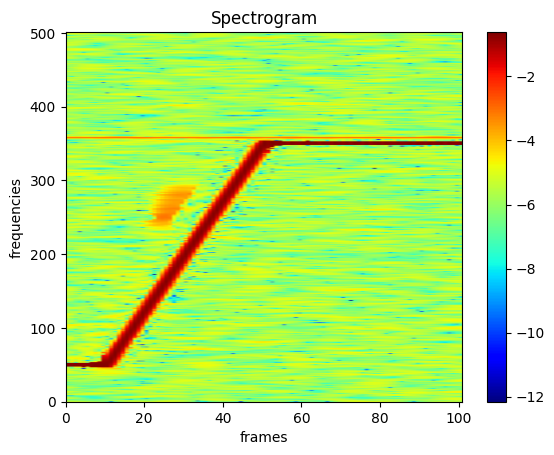

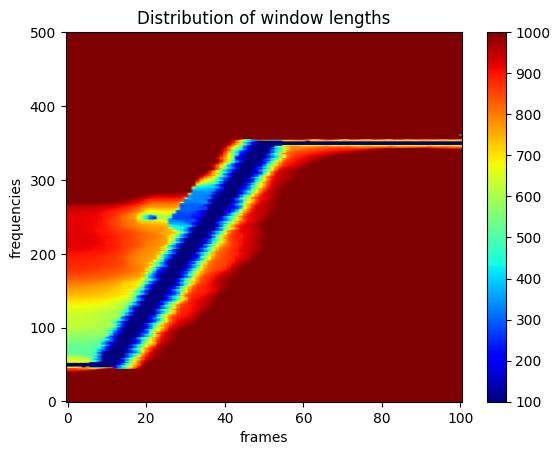

In [103]:
dstft = ADSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

times = []
for epoch in range(1_000):
    tic()
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    times.append(toc(print_elapsed=False))
avgtime = sum(times) / len(times)
print(f"average time per iteration: {avgtime:.4f} seconds")  
    
print(epoch)
dstft.plot(spec, x, bar=True, wins=False)

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/DSTFT/dstft/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


290


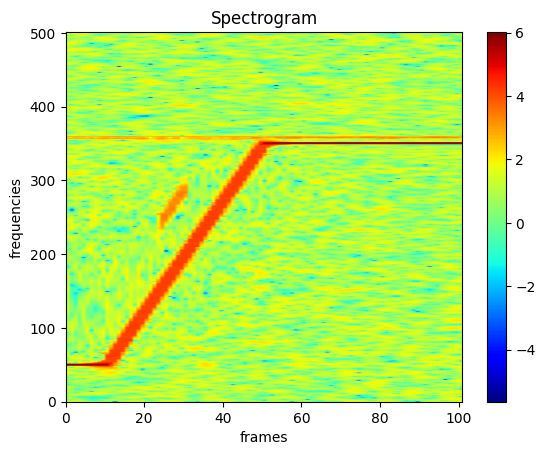

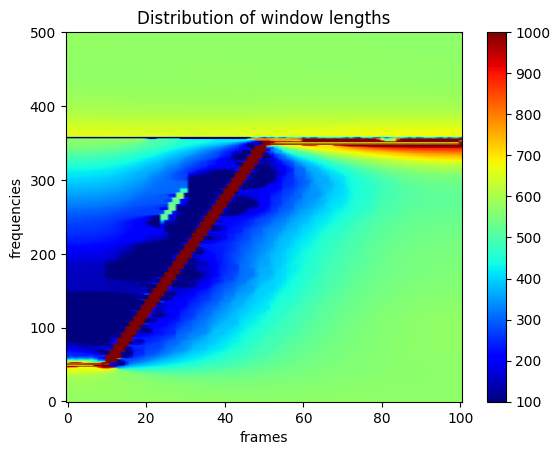

In [ ]:
dstft = ADSTFTenergy(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
spec, *_ = dstft.abs_forward(x)
dstft.plot(spec, x, bar=True, wins=False)

In [ ]:
dstft = ADSTFTenergy(x, win_length=1000, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
spec, *_ = dstft.abs_forward(x)
dstft.plot(spec, x, bar=True, wins=False)

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/projekt-fmsn35/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

87


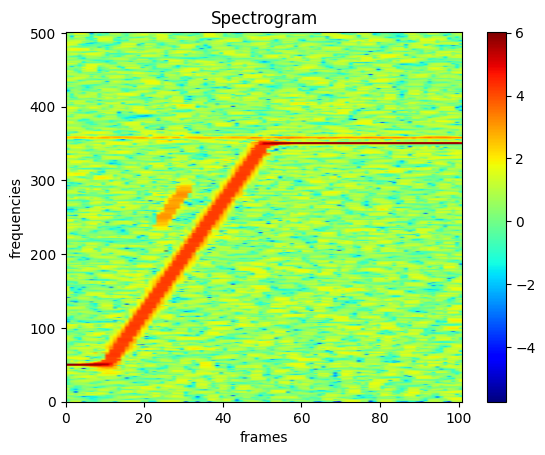

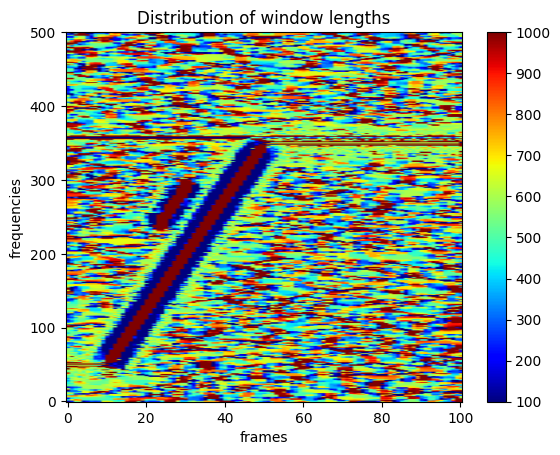

In [10]:
dstft = ADSTFTenergy(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(device)

params = [{'params': dstft.win_length,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    #print(epoch)
    opt.zero_grad()
    spec, *_ = dstft(x)
    #print(spec.shape)
    err = entropy_loss(spec) + 0.0001* (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
spec, *_ = dstft.abs_forward(x)
dstft.plot(spec, x, bar=True, wins=False)

/Users/kaspernordenram/Desktop/Skola/LTH/Mitt år 5/FMSN35/Projekt/projekt-fmsn35/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


average time per iteration: 0.0236 seconds
average time per iteration: 0.0250 seconds
average time per iteration: 0.0317 seconds
average time per iteration: 0.0276 seconds
average time per iteration: 0.0315 seconds
average time per iteration: 0.0289 seconds
average time per iteration: 0.0313 seconds
average time per iteration: 0.0302 seconds
average time per iteration: 0.0299 seconds
average time per iteration: 0.0297 seconds


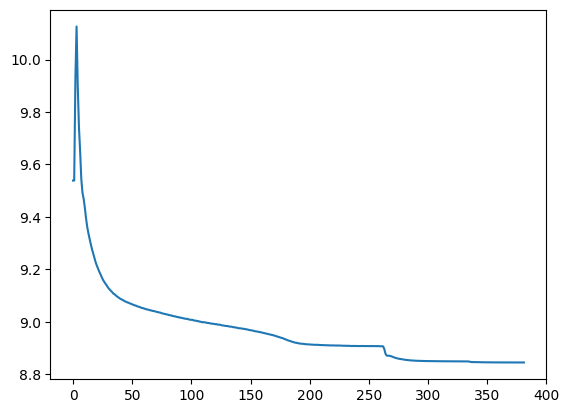

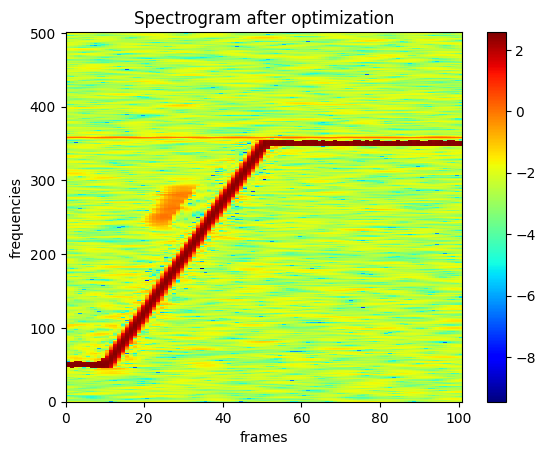

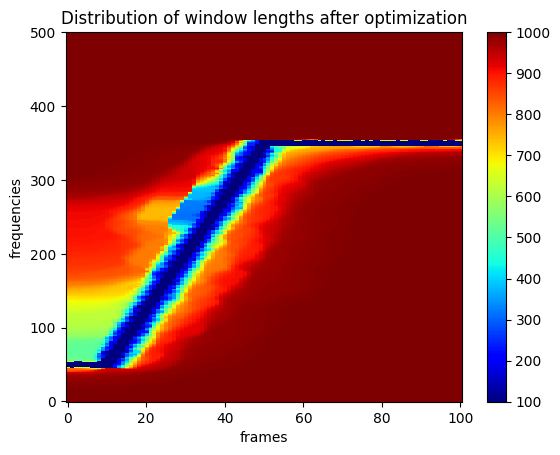

100.0 1000.0 901.63666
finished on epoch 380 with (unregularized) loss 8.717056274414062


'window_lengths = fastdstft.window_lengths\npadding_size = (1000 - window_lengths.size(0))  # Should be 499\nreflected_part = window_lengths[-padding_size:].flip(0)  # Flip along the first dimension (rows)\npadded_window_lengths = torch.cat([window_lengths, reflected_part], dim=0)\nwindow_lengths_param = torch.nn.Parameter(padded_window_lengths)\ndstft.win_length = window_lengths_param\nspec, *_ = dstft(x)\nfastdstft.plot(spec, title="dstft with weights from fastdstft optimization")\nprint(f"loss for dstft: {entropy_loss(spec).item()}")'

In [ ]:
from dstft import fastDSTFT
import numpy as np

#for i in range(10):
fastdstft = fastDSTFT(x, 
                    window_function='beta', 
                    spline_density=2, 
                    initial_win_length=500, 
                    support=1_000, 
                    stride=50,
                    warm_start=False)  # not implemented yet
fastdstft.precompute()
#fastdstft = torch.compile(fastdstft)  # ingen skillnad

params = [{'params': fastdstft.window_lengths,'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=19, verbose=True)

spec = fastdstft()

reg = 0.01
errs = []
err = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
errs.append(err.item())
times = []
for epoch in range(1_000):
    tic()
    opt.zero_grad()
    spec = fastdstft()  #(), low_memory_forward()
    err = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)

    fastdstft.put_windows_back()  # putting window lengths back in the range [100, 1000]

    errs.append(err.item())

    if opt.param_groups[0]['lr'] < 1:
        break
    times.append(toc(print_elapsed=False))
avgtime = sum(times) / len(times)
print(f"average time per iteration: {avgtime:.4f} seconds")  
# takes 0.0250 with normal, 0.0750 with low_memory, as compared to 2.3850 for the ADSTFT. A speedup of 100x with normal. 
# And it is possible to optimize more, probably 100% more by precomputating all the splines.

plt.plot(errs)
plt.show()

spec = fastdstft()
fastdstft.plot(spec, title="after optimization")

window_lengths = fastdstft.window_lengths.detach().cpu().numpy()
print(window_lengths.min(), window_lengths.max(), window_lengths.mean())
print(f"finished on epoch {epoch} with (unregularized) loss {entropy_loss(spec).item()}")

#print(np.array(fastdstft.times1).mean())  # unnecessary computations
#print(np.array(fastdstft.times2).mean())  # necessary computations, they are the same

"""window_lengths = fastdstft.window_lengths
padding_size = (1000 - window_lengths.size(0))  # Should be 499
reflected_part = window_lengths[-padding_size:].flip(0)  # Flip along the first dimension (rows)
padded_window_lengths = torch.cat([window_lengths, reflected_part], dim=0)
window_lengths_param = torch.nn.Parameter(padded_window_lengths)
dstft.win_length = window_lengths_param
spec, *_ = dstft(x)
fastdstft.plot(spec, title="dstft with weights from fastdstft optimization")
print(f"loss for dstft: {entropy_loss(spec).item()}")"""